# FairWorkflows execution demo

## Define the steps of your workflow
Each step should be its own function. Mark the function as such with the @fairstep decorator.

In [15]:
from fairworkflows import is_fairworkflow, is_fairstep, FairWorkflow

In [16]:
@is_fairstep(label='Addition')
def add(a:float, b:float) -> float:
    """Adding up numbers!"""
    return a + b

In [17]:
@is_fairstep(label='Subtraction')
def sub(a: float, b: float) -> float:
    """Subtracting numbers."""
    return a - b

In [18]:
@is_fairstep(label='Multiplication')
def mul(a: float, b: float) -> float:
    """Multiplying numbers."""
    return a * b

In [19]:
@is_fairstep(label='A strange step with little use')
def weird(a: float, b:float) -> float:
    """A weird function"""
    return a * 2 + b * 4
    

## Define your workflow using @fairworkflow
Now write a function which describes your workflow. Mark this function with the @fairworkflow decorator.

In [20]:
@is_fairworkflow(label='My Workflow')
def my_workflow(in1, in2, in3):
    """
    A simple addition, subtraction, multiplication workflow
    """
    t1 = add(in1, in2)
    t2 = sub(in1, in2)
    t3 = mul(weird(t1, in3), t2)
    return t3

## Create an instance of your workflow and display it

In [21]:
fw = FairWorkflow.from_function(my_workflow)
type(fw)

fairworkflows.fairworkflow.FairWorkflow

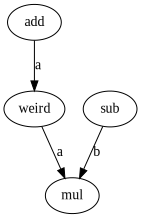

In [23]:
fw.display()

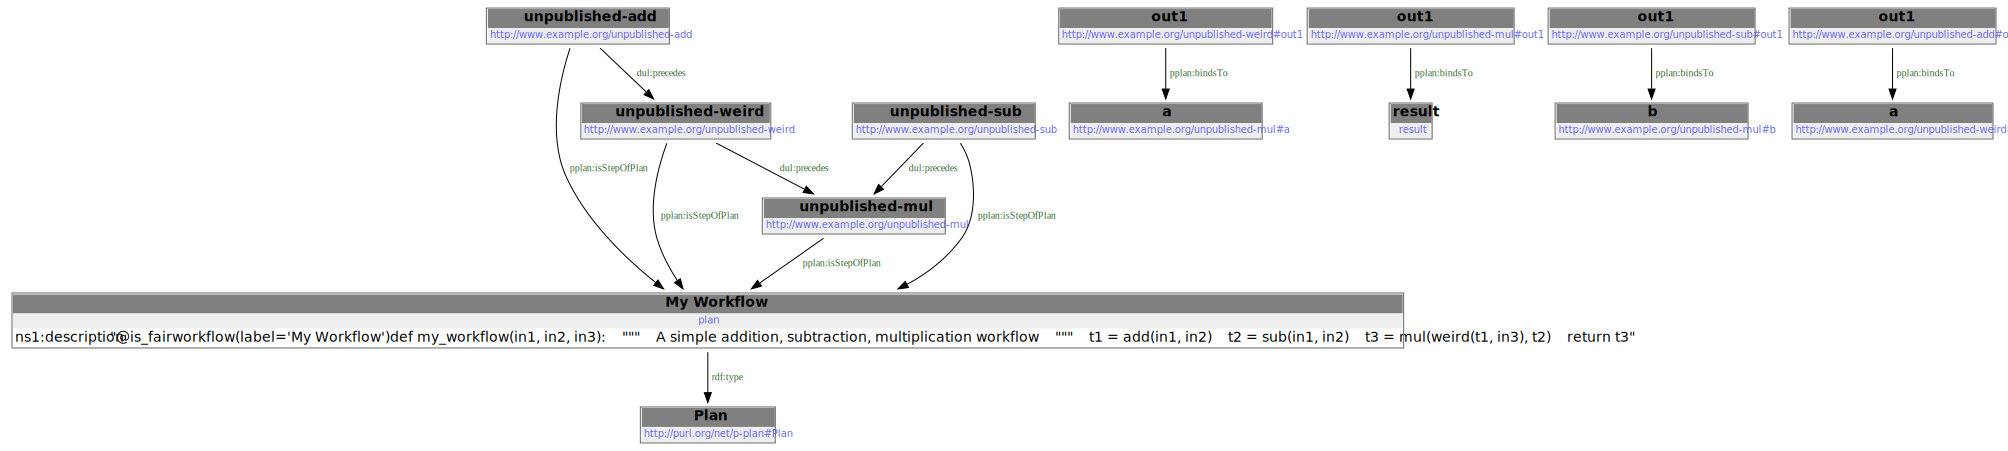

In [24]:
fw.display_rdf()

## Publish the (prospective) workflow
You may publish the workflow, and its steps, as nanopublications in the usual manner:

In [9]:
#fw.publish_as_nanopub()

Be warned though - the above will keep publishing to the 'real' nanopub server network. For testing you may prefer to publish to the test servers as follows (note that this will refuse to publish a workflow you have already published :

In [12]:
fw.publish_as_nanopub(use_test_server=True)

Published to http://purl.org/np/RAWarWs5kFRYx0vtzhYPrl9xzY53MKDEfzYMp09fZGEWY
Published concept to http://purl.org/np/RAWarWs5kFRYx0vtzhYPrl9xzY53MKDEfzYMp09fZGEWY#plan


{'nanopub_uri': 'http://purl.org/np/RAWarWs5kFRYx0vtzhYPrl9xzY53MKDEfzYMp09fZGEWY',
 'concept_uri': 'http://purl.org/np/RAWarWs5kFRYx0vtzhYPrl9xzY53MKDEfzYMp09fZGEWY#plan'}

You can then find your nanopublications by replacing the base of the URI with http://test-server.nanopubs.lod.labs.vu.nl/

## Execute your workflow using .execute()
Set num_threads greater than 1 if you wish to exploit parallelisation in your workflow. The retrospective provenance is also returned as a (nano) Publication object, that can optionally be published.

In [13]:
result, prov = fw.execute(1, 4, 3)
result

-66

 ## Retrospective prov
 The retrospective prov object is not yet implemented, pending one of the RDF tasks set out in the planning document. For now, you may see simply the provenance trace for this run. We wish to turn this into a (Plex) RDF nanopublication:
 
THIS IS BROKEN, WILL BE FIXED IN #168

In [14]:
type(prov)

nanopub.publication.Publication

In [15]:
print(prov)

Original source URI = None
@prefix : <http://purl.org/nanopub/temp/mynanopub#> .
@prefix np: <http://www.nanopub.org/nschema#> .
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

:assertion {
    :retroprov a prov:Activity ;
        rdfs:label "" ;
        prov:wasDerivedFrom <http://purl.org/np/RAWarWs5kFRYx0vtzhYPrl9xzY53MKDEfzYMp09fZGEWY#plan> .
}

:provenance {
    :assertion prov:generatedAtTime "2021-02-09T07:26:44.473167"^^xsd:dateTime .
}

:Head {
    : a np:Nanopublication ;
        np:hasAssertion :assertion ;
        np:hasProvenance :provenance ;
        np:hasPublicationInfo :pubInfo .
}

:pubInfo {
    : prov:generatedAtTime "2021-02-09T07:26:44.473167"^^xsd:dateTime ;
        prov:wasAttributedTo <https://orcid.org/1234-1234-1234-1234> .
}




### Provide semantic annotations for input and output variables
If you wish to specify semantic types for the inputs/outputs to a step, you can do so in the arguments to the decorator.
For example, if you have an input parameter 'a', you can write a='http://www.example.org/distance' to assign that (semantic) type to a. As output of functions is not named in python, you can specify the same but with 'out1', 'out2' etc. See the following example:

In [8]:
@is_fairstep(label='Addition', a='http://www.example.org/distance', returns='http://www.example.org/mass')
def add(a:float, b:float) -> float:
    return a + b

If we now look at the RDF generated for the step, we will see that input parameter 'a' and the step output ('out1') both have the (additional) semantic types specified.

In [3]:
# ACTIONS:
# Add language and version to nanopubs (i.e. what the description is written in)
print(add._fairstep)

Step URI = http://www.example.org/unpublished-add
@prefix bpmn: <http://dkm.fbk.eu/index.php/BPMN2_Ontology#> .
@prefix ns1: <http://purl.org/dc/terms/> .
@prefix pplan: <http://purl.org/net/p-plan#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

_:Nda081d4e75bc47f0a65dc6134c6ca5e0 {
    [] a bpmn:ScriptTask,
            pplan:Step ;
        rdfs:label "Addition" ;
        ns1:description """@is_fairstep(label='Addition', a='http://www.example.org/distance', out='http://www.example.org/mass')
def add(a:float, b:float) -> float:
    return a + b
""" ;
        pplan:hasInputVar [ a pplan:Variable,
                    <http://www.example.org/distance> ;
                rdfs:label "a" ;
                rdfs:comment "float" ],
            [ a pplan:Variable ;
                rdfs:label "b" ;
                rdfs:comment "float" ] ;
        pplan:hasOutputVar [ a pplan:Variable,
                    <http://www.example.org/mass> ;
                rdfs:label "out1" ;
              

### Specify more than one semantic type for a parameter
You can provide a list of URIs if you want to specify several semantic types for e.g. parameter 'a':

In [6]:
@is_fairstep(label='Addition', a=['http://www.example.org/distance', 'http://www.example.org/number'])
def another_step(a:float, b:float) -> float:
    return a + b

In [7]:
print(another_step._fairstep)

Step URI = http://www.example.org/unpublished-another_step
@prefix bpmn: <http://dkm.fbk.eu/index.php/BPMN2_Ontology#> .
@prefix ns1: <http://purl.org/dc/terms/> .
@prefix pplan: <http://purl.org/net/p-plan#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

_:N94e43cf479454578b20e9b3b1efd89ca {
    [] a bpmn:ScriptTask,
            pplan:Step ;
        rdfs:label "Addition" ;
        ns1:description """@is_fairstep(label='Addition', a=['http://www.example.org/distance', 'http://www.example.org/number'])
def another_step(a:float, b:float) -> float:
    return a + b
""" ;
        pplan:hasInputVar [ a pplan:Variable,
                    <http://www.example.org/distance>,
                    <http://www.example.org/number> ;
                rdfs:label "a" ;
                rdfs:comment "float" ],
            [ a pplan:Variable ;
                rdfs:label "b" ;
                rdfs:comment "float" ] ;
        pplan:hasOutputVar [ a pplan:Variable ;
                rdfs:label "ou

## Semantic types for function producing multiple outputs
Provide 'out' with a tuple of the same length as the number of function outputs. You can use None for any you do not wish to assign a particular semantic type to.

In [6]:
from typing import Tuple
@is_fairstep(label='Addition and subtraction', returns=('http://www.example.org/distance', 'http://www.example.org/number'))
def another_step(a:float, b:float) -> Tuple[float, float]:
    return a + b, a - b

In [7]:
print(another_step._fairstep)

Step URI = http://www.example.org/unpublished-another_step
@prefix bpmn: <http://dkm.fbk.eu/index.php/BPMN2_Ontology#> .
@prefix ns1: <http://purl.org/dc/terms/> .
@prefix pplan: <http://purl.org/net/p-plan#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

_:Nbfca224ce79741f685b6430a1cdb1d74 {
    [] a bpmn:ScriptTask,
            pplan:Step ;
        rdfs:label "Addition and subtraction" ;
        ns1:description """@is_fairstep(label='Addition and subtraction', returns=('http://www.example.org/distance', 'http://www.example.org/number'))
def another_step(a:float, b:float) -> Tuple[float, float]:
    return a + b, a - b
""" ;
        pplan:hasInputVar [ a pplan:Variable ;
                rdfs:label "a" ;
                rdfs:comment "float" ],
            [ a pplan:Variable ;
                rdfs:label "b" ;
                rdfs:comment "float" ] ;
        pplan:hasOutputVar [ a pplan:Variable,
                    <http://www.example.org/distance> ;
                rdfs:lab

As before, you may provide a list of URIs for each output. If you do not want to provide semantic types for a particular output, simply pass None:

In [2]:
from typing import Tuple
@is_fairstep(label='Addition and subtraction', returns=(['http://www.example.org/distance', 'http://www.example.org/number'], None))
def another_step(a:float, b:float) -> Tuple[float, float]:
    return a + b, a - b

In [3]:
print(another_step._fairstep)

Step URI = http://www.example.org/unpublished-another_step
@prefix bpmn: <http://dkm.fbk.eu/index.php/BPMN2_Ontology#> .
@prefix ns1: <http://purl.org/dc/terms/> .
@prefix pplan: <http://purl.org/net/p-plan#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

_:Nfd09bd8a8a4c48a1b2e2e240411aad92 {
    [] a bpmn:ScriptTask,
            pplan:Step ;
        rdfs:label "Addition and subtraction" ;
        ns1:description """@is_fairstep(label='Addition and subtraction', returns=(['http://www.example.org/distance', 'http://www.example.org/number'], None))
def another_step(a:float, b:float) -> Tuple[float, float]:
    return a + b, a - b
""" ;
        pplan:hasInputVar [ a pplan:Variable ;
                rdfs:label "a" ;
                rdfs:comment "float" ],
            [ a pplan:Variable ;
                rdfs:label "b" ;
                rdfs:comment "float" ] ;
        pplan:hasOutputVar [ a pplan:Variable,
                    <http://www.example.org/distance>,
                 